In [2]:
import torch
from boltzmanngen.model._build import model_from_config
from boltzmanngen.train.loss import Loss, LossStat
import numpy as np
from boltzmanngen.data import DataConfig, IndexBatchIterator
from boltzmanngen.distribution import Energy, GaussianMCMCSampler, BoltzmannGenerator
from boltzmanngen.utils.types import assert_numpy
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as stats

In [4]:
def plot_energy(energy, extent=(-4., 4.), resolution=100, dim=2):
    """ Plot energy functions in 2D """
    xs = torch.meshgrid([torch.linspace(*extent, resolution) for _ in range(2)])
    xs = torch.stack(xs, dim=-1).view(-1, 2)
    xs = torch.cat([
        xs,
        torch.Tensor(xs.shape[0], dim - xs.shape[-1]).zero_()
    ], dim=-1)
    us = energy.energy(xs).view(resolution, resolution)
    us = torch.exp(-us)
    plt.imshow(assert_numpy(us), extent=extent * 2)
    plt.xlim=(extent[0], extent[1])
    plt.ylim=(extent[0], extent[1])
    del xs, us

def plot_samples(samples, weights=None, range=None):
    """ Plot sample histogram in 2D """
    samples = assert_numpy(samples)
    h = plt.hist2d(
        samples[:, 0], 
        samples[:, 1],
        weights=assert_numpy(weights) if weights is not None else weights,
        bins=100,
        norm=matplotlib.colors.LogNorm(),
        range=range,
    )
    plt.colorbar(h[3])

def plot_bg(bg, target, n_samples=10000, range=[-4., 4.], dim=2):
    """ Plot target energy, bg energy and bg sample histogram"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plot_energy(target, extent=range, dim=dim)
    plt.title("Target energy")
    plt.subplot(1, 3, 2)
    plot_energy(bg, extent=range, dim=dim)
    plt.title("BG energy")
    plt.subplot(1, 3, 3)
    plot_samples(bg.sample(n_samples)["x"], range=[range, range])
    plt.title("BG samples")

def plot_weighted_energy_estimate(bg: BoltzmannGenerator, target: Energy, dim: int, n_samples=10000, n_bins=100, range=[-2.5, 2.5]):
    """ Plot weighed energy from samples """
    result = bg.sample(n_samples)
    samples, latent, dlogp = result["x"], result["z"], result["dlogp"]
    log_weights = bg.log_weights(samples, latent, dlogp)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=None, density=True, label="samples", range=range)
    xs = torch.linspace(*range, n_bins).view(-1, 1)
    xs = torch.cat([xs, torch.zeros(xs.shape[0], dim - 1)], dim=-1).view(-1, dim)
    us = target.energy(xs).view(-1)
    us = torch.exp(-us)
    us = us / torch.sum(us * (bins[-1] - bins[0]) / n_bins)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.ylabel("log density")
    plt.legend()
    plt.title("unweighed energy")
    
    plt.subplot(1, 3, 2)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=assert_numpy(log_weights.exp()), density=True, label="samples", range=range)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.legend()
    plt.title("weighed energy")

    plt.subplot(1, 3, 3)
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plot_samples(samples, weights=log_weights.exp(), range=[range, range])
    plt.title("weighed samples")
    del result, samples, latent, dlogp, log_weights

def plot_potential(X: torch.Tensor, cbar=True, orientation='vertical', figsize=(4, 5.5), rng=[-5, 5], vmax=300):
    # 2D potential
    xgrid = torch.linspace(rng[0], rng[1], 100)
    ygrid = torch.linspace(rng[0], rng[1], 100)
    Xgrid, Ygrid = torch.meshgrid(xgrid, ygrid)
    grid = torch.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(grid)
    E = E.reshape((100, 100))
    E = torch.min(E, torch.tensor(vmax))
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=vmax)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([0, vmax/2, vmax])
    plt.scatter(X[:, 0], X[:, 1], c=range(len(X)), cmap='viridis', marker='+', s=1)
    plt.xticks([rng[0], 0, rng[1]])
    plt.yticks([rng[0], 0, rng[1]])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

def plot_prior(Z: torch.Tensor, cbar=True, orientation='vertical', figsize=(4, 5.5)):
    # 2D potential
    xgrid = torch.linspace(-5, 5, 100)
    ygrid = torch.linspace(-5, 5, 100)
    Xgrid, Ygrid = torch.meshgrid(xgrid, ygrid)
    grid = torch.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = torch.from_numpy(stats.multivariate_normal.pdf(grid, mean=[0, 0], cov=[1, 1]))
    E = E.reshape((100, 100))
    E = torch.min(E, torch.tensor(1.0))
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=torch.max(E))
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([0, torch.max(E)/2, torch.max(E)])
    plt.scatter(Z[:, 0], Z[:, 1], c=range(len(Z)), cmap='viridis', marker='+', s=1)
    plt.xticks([-5, 0, 5])
    plt.yticks([-5, 0, 5])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

def hist_weights(X, log_weights):
    bins = np.linspace(-2.5, 2.5, 100 + 1)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(X[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_weights)):
        whist[sample_x_index[i]] += np.exp(log_weights[i])
    return bin_means, whist[1:-1]

def plot_network(X_left, X_transition, X_right, weight_cutoff=1e-2):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5))
    plt.subplots_adjust(wspace=0.25)
    # Plot X distribution
    axis = axes[0]
    axis.plot(X_left[:, 0], X_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(X_transition[:, 0], X_transition[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(X_right[:, 0], X_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    axis.set_xlabel('$x_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$x_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4])
    # Plot Z distribution
    axis = axes[1]
    zs = []
    for x in [X_left, X_transition, X_right]:
        data = {
                DataConfig.INPUT_KEY: x.to(device)
            }

        _out = model(data, inverse=True)
        zs.append(_out[DataConfig.OUTPUT_KEY].detach().cpu().numpy())
    for c, z in zip(['blue', 'orange', 'red'], zs):
        axis.plot(z[:, 0], z[:, 1], linewidth=0, marker='.', markersize=3, color=c)
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4])
    del _out, zs

    # Plot proposal distribution
    result = bg.sample(10000)
    X, log_weights = result["x"].detach().cpu(), result["log_weights"].detach().cpu()

    temperature = 1.0
    H, bins = np.histogram(X[:, 0], bins=100)
    bin_means = 0.5*(bins[:-1] + bins[1:])
    Eh = -np.log(H) / temperature
    X1, Y1 = bin_means, Eh
    X1, W1 = hist_weights(X, log_weights)
    axis = axes[2]
    x_grid = np.linspace(-3, 3, num=200)
    x_grid = np.c_[ x_grid, np.ones(len(x_grid))]
    E = assert_numpy(double_well._energy(torch.from_numpy(x_grid)) / 1.0)
    axis.plot(x_grid, E, linewidth=3, color='black')
    Y1 = Y1 - Y1.min() + E.min()

    Inan = np.where(W1 < weight_cutoff)
    Y1[Inan] = np.nan
    axis.plot(X1, Y1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([])
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('Energy / kT')
    plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)

    del result, X, log_weights
    return fig, axes

def plot_transition_traj(A, B, points = 10000, show_prior = False, rng=[-5, 5], vmax=300):
    X1 = A.to(device)
    X2 = B.to(device)
    x = torch.stack([X1, X2])

    data = {
                DataConfig.INPUT_KEY: x.to(device)
            }
    data = model(data, inverse=True)
    z = data[DataConfig.OUTPUT_KEY]
    z0 = torch.linspace(z[0,0].item(), z[1, 0].item(), points)
    z1 = torch.linspace(z[0,1].item(), z[1, 1].item(), points)
    z = torch.stack([z0, z1]).T

    data = {
                DataConfig.INPUT_KEY: z.to(device)
            }
    data = model(data)
    x = data[DataConfig.OUTPUT_KEY]

    R = X2 - X1
    centered_x = x - X1
    path_positions = torch.matmul(centered_x, R).div((R).pow(2).sum(0) + 1e-10)
    path_evolution = torch.linspace(0.0, 1.0, points).to(device)
    data[DataConfig.OUTPUT_KEY] = x[torch.argmin(torch.abs(path_evolution[..., None] - path_positions[None, ...]), dim=1)]

    loss, loss_contrib = bg._loss(pred=data, temperature=1.0, direction=DataConfig.Z_TO_X_KEY, explore=1.0)
    print(loss.mean())

    if show_prior:
        plot_prior(Z=z.detach().cpu(), orientation="horizontal")
    plot_potential(X=x.detach().cpu(), orientation="horizontal", rng=rng, vmax=vmax)

In [5]:
config = {
    "model_builders": ["InvertibleModel", "ModelJacobian"],
    "num_layers": 10,
    "loss_params": {
        ("y", "J", "zx"): [
            "JKLLoss",
            1.0,
            {
                "energy_model": "MultimodalEnergy",
                "params": {
                    'dim': 2,
                }
                # "energy_model": "ShiftedDoubleWellEnergy",
                # "params": {
                #     'a' : 0.0,
                #     'b' : -2.0,
                #     'c' : 0.5,
                #     'dim' : 2,
                # },
            },
        ],
        ("y", "J", "xz"): [
            "MLLoss",
            1.0,
            {
                "energy_model": "NormalDistribution",
                "params": {
                    'mean': torch.tensor([0.0, 0.0]),
                    'cov': torch.tensor([[1.0, 0.0],[0.0, 1.0]]),
                    'dim' : 2,
                },
            },
        ],
        ("y", "J", "saddle"): [
            "HessianLoss",
            1.0,
            {
                "energy_model": "MultimodalEnergy",
                "params": {
                    'dim': 2,
                },
            },
        ],
        ("y", "J", "path"): [
            "PathLoss",
            1.0,
            {
                "energy_model": "MultimodalEnergy",
                "params": {
                    'dim': 2,
                },
                "sigma": 3.0,
                "logp_eps": [1e-10, 1e-2],
                "hist_volume_expansions": [0.4, 2.0],
            },
        ],
    }
}

device = "cuda:1"
model = model_from_config(config).to(device)
model.train()

loss_f, target, prior, _, _ = Loss.from_config(config)
loss_stat = LossStat().to(device)
double_well = loss_f.funcs[(DataConfig.OUTPUT_KEY, DataConfig.JACOB_KEY, DataConfig.Z_TO_X_KEY)].energy_model

target = target.to(device)
prior = prior.to(device)

bg = BoltzmannGenerator(prior, model, target, loss_f).to(device)

/home/angiod@usi.ch/paper_boltzmann_generators/venv/lib64/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


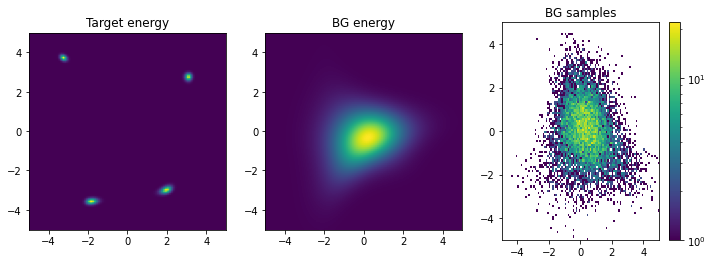

In [6]:
rng = [-5.0, 5.0]
vmax = 300
plot_bg(bg, target, dim=2, range=rng)
#plot_weighted_energy_estimate(bg, target, dim=2, range=rng)

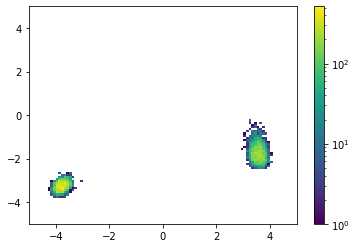

In [7]:
init_state = torch.Tensor([[4., -2.], [-3., -3.]]) # init_state = torch.Tensor([[4., -2.], [-3., -3.]]) <- multimodal
target_sampler = GaussianMCMCSampler(target, init_state=init_state, noise_std=0.5, uniform_range=[0, 1e-1])

data = target_sampler.sample(10000)
X_left = data[data[:, 0] < 0]
X_right = data[data[:, 0] > 0]

plot_samples(data, range=[rng, rng])

In [8]:
n_kl_samples = 1000
n_batch = 1000
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=1e-4)

epochs = 50
path_epoch = 40
batch_log_freq = 5

lambdas = torch.linspace(1.0, 0.0, epochs).to(device)

In [7]:
model.train()
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs]

        optim.zero_grad()

        nll = bg.energy(batch).mean()
        loss_stat(nll, bg.loss_contrib)

        (lamb * nll).backward()

        kll = bg.kldiv(n_kl_samples, explore=1.0).mean()
        loss_stat(kll, bg.loss_contrib)

        ((1. - lamb) * kll).backward()

        # if epoch >= path_epoch - 1:
        #     left = batch[batch[:, 0] < 0]
        #     right = batch[batch[:, 0] > 0]
        #     x = torch.vstack([left[0], right[0]])
        #     path = bg.path(n_kl_samples, path_weight=0.5, x=x).mean()
        #     if epoch >= path_epoch:
        #         loss_stat(path, bg.loss_contrib)
        #         path.backward()

        # hess = bg.saddle(n_kl_samples).mean()
        # loss_stat(hess, bg.loss_contrib)
        # hess.backward()

        optim.step()

        if it % batch_log_freq == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}".format(
                    epoch + 1,
                    it,
                    len(batch_iter),
                    lamb,
                ), loss_stat.current_result(), end="")

epoch: 50, iter: 15/20, lambda: 0.0 {'loss_Jml': 5.276654243469238, 'loss_Jkl': 21.53864288330078, 'loss': 13.4076566696167}89}571931838989258}}

In [11]:
mw = [
    "multimodal_nll+kll_transition.pth",
    "multimodal_nll+kll_no_transition.pth",
    "multimodal_nll+hess_no_transition.pth",
    "multimodal_nll+hess+kll_no_transition.pth",
    "multimodal_nll+path_no_transition.pth",
    "multimodal_nll+path+orth_no_transition.pth",
    "multimodal_nll+path+orth+kll_no_transition.pth",
    "holders_nll+path+orth.pth",
]
model_weights = mw[6]

In [12]:
# torch.save(model.state_dict(), model_weights)

In [13]:
model.load_state_dict(torch.load(model_weights))
model = model.eval()

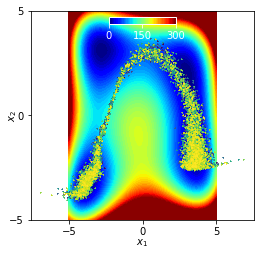

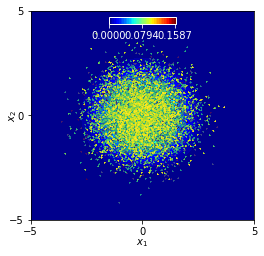

In [14]:
# plot_bg(bg, target, dim=2, range=[-4., 4.])
# plot_weighted_energy_estimate(bg, target, dim=2)

result = bg.sample(10000)
X, Z = result["x"], result["z"]

plot_potential(X=X.detach().cpu(), orientation="horizontal", rng=rng, vmax=vmax)
plot_prior(Z=Z.detach().cpu(), orientation="horizontal")

del result, X, Z

/tmp/ipykernel_2427999/2426557642.py:191: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(H) / temperature


(<Figure size 1152x252 with 3 Axes>,
 array([<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:xlabel='$z_1$', ylabel='$z_2$'>,
        <AxesSubplot:xlabel='$x_1$', ylabel='Energy / kT'>], dtype=object))

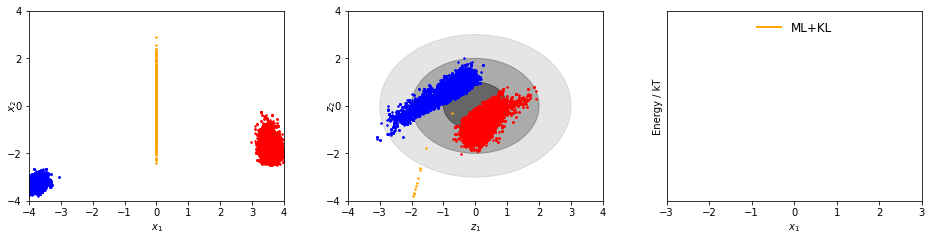

In [15]:
X_transition = torch.zeros((500, 2), dtype=torch.float32)
X_transition[:, 1] = torch.randn(500)

plot_network(X_left=X_left, X_transition=X_transition, X_right=X_right)

tensor(69.3481, device='cuda:1', grad_fn=<MeanBackward0>)


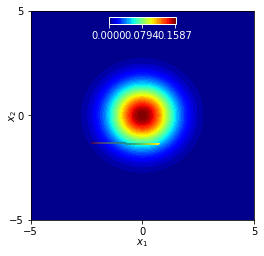

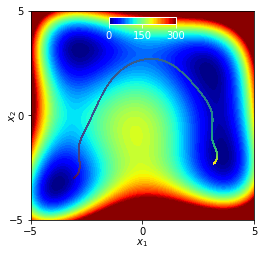

In [16]:
plot_transition_traj(X_left[0], X_right[0], show_prior=True, rng=rng, vmax=vmax)

tensor(64.4768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(61.5403, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(62.2390, device='cuda:1', grad_fn=<MeanBackward0>)


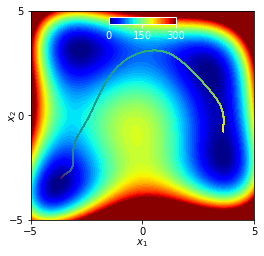

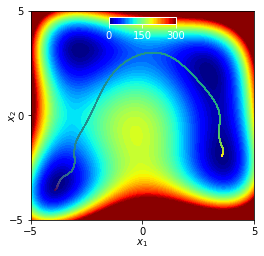

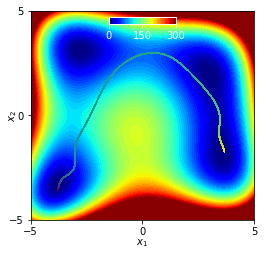

In [17]:
for _ in range(3):
    plot_transition_traj(X_left[np.random.randint(0, len(X_left))], X_right[np.random.randint(0, len(X_right))])

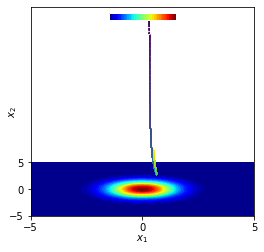

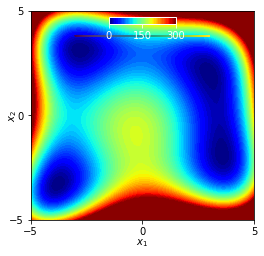

In [20]:
X1 = torch.tensor([-3, 3.8]).to(device)
X2 = torch.tensor([3, 3.8]).to(device)
x0 = torch.linspace(X1[0].item(), X2[0].item(), 1000)
x1 = torch.linspace(X1[1].item(), X2[1].item(), 1000)
x = torch.stack([x0, x1]).T

data = {
            DataConfig.INPUT_KEY: x.to(device)
        }
data = model(data, inverse=True)
z = data[DataConfig.OUTPUT_KEY]
plot_prior(Z=z.detach().cpu(), orientation="horizontal")
plot_potential(X=x.detach().cpu(), orientation="horizontal", rng=rng, vmax=vmax)